In [4]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

In [11]:
np.cov(X, Y)[0,1]

0.00025805156619051139

In [10]:
np.cov(X, Y)

array([[ 0.0004824 ,  0.00025805],
       [ 0.00025805,  0.0002303 ]])

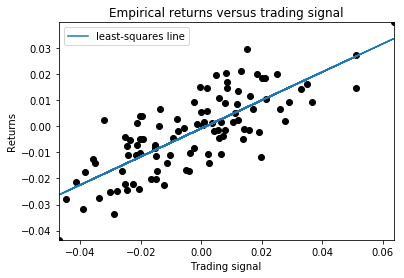

In [5]:
#generating fake data

N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("Trading signal")
plt.ylabel("Returns")
plt.title("Empirical returns versus trading signal")
plt.plot(X, ls_coef_ * X + ls_intercept, label="least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");



In [6]:
import pymc as pm
from pymc.Matplot import plot as mcplot

std = pm.Uniform("std", 0, 100, trace=False)

@pm.deterministic
def prec(U=std):
    return 1.0 / U **2

beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)

@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([obs, beta, alpha, std, prec])

mcmc.sample(100000, 80000);

 [-----------------100%-----------------] 100000 of 100000 complete in 11.1 sec

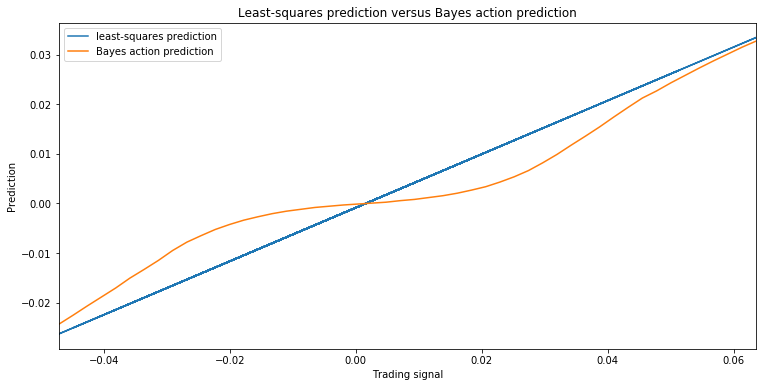

In [9]:
figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    sol = np.zeros_like(price)
    ix = price*pred < 0
    sol[ix] = coef * pred **2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]
N = tau_samples.shape[0]

noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal +noise


opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
       _possible_outcomes = possible_outcomes(_signal)
       tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
       opt_predictions[i] = fmin(tomin, 0, disp=False)
        
        
        
plt.xlabel("Trading signal")
plt.ylabel("Prediction")
plt.title("Least-squares prediction versus Bayes action prediction")
plt.plot(X, ls_coef_ * X + ls_intercept,
          label="least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions,
          label="Bayes action prediction")
plt.legend(loc="upper left");